<h1 align="center">Enlighten Health</h1>

<h4 align="center">Predictive analysis of chronic conditions in patients to try and diagnose latent health issues that may have been missed</h4>

#### Ref:
Data: https://meps.ahrq.gov/mepsweb/

## Setup

In [1]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import pandas as pd
import seaborn as sns
import collections
import matplotlib.pyplot as plt
sns.set()

In [2]:
import sklearn.externals.joblib as jl

from sklearn import preprocessing
# from sklearn.cross_validation import train_test_split
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
raw_df = pd.DataFrame.from_csv("./meps_base_data.csv")  # Database of patients
raw_meds = pd.DataFrame.from_csv("./meps_meds.csv")  # Database of medications
raw_cond = pd.DataFrame.from_csv("./meps_conditions.csv")  # Database of conditions

## Gather ideas

- Using quantity of medicine as a possible indication of intensity of illness and/or power of that medication?
- Pooled weight? I found this: '“pooled weight” is the yearly person weight divided by the number of years (i.e., 6)'. But that wasn't very useful. Another possibility is the weight being in ounces, but why would it have 6 digits of precision.
- A good indication of certainty of a medicine implying an illness?
    - Appearance divided by total medications present for that illness?
- Average number of medications for each diagnosis
- Appearance of each medicine in each diagnosis
- Correlation between diseases (correlation between different columns, but we have to keep in mind that some people's diagnosis is not available. We can either include those in this calculation too or just replace all of them with 0 and have three options: yes, no, and NA.
- Model options: 
    - We can only include whether a patient with a disease is getting a medication or not
    - Include the quantity of medicine for each patient as an indication of importance of that medicine for that disease
    - Including other features, e.g. sex, weight, age, etc. 

## Guide

* **raw_df**: the raw dataframe that we keep as a refenrece
* **df**: derived from raw_df, all main operations are done on this dataframe
* **meds_df**: derived from raw_meds to be added to df
* **rank_df**: rank of appearance of each medication in each disease
* **dist_df**: distance of each medication's rank in different diseases.

* **list_med_ranks**: list of medication rankings, used to construct rank_df
* **df_non_list**: list of dataframes with patients that have only one disease

## Useful functions

In [4]:
def most_common_med(df, condition=None):
    """
    Get the names and codes of the most frequent medications for each condition
    """
    # List of diseases that are considered in this scope
    conditions = ['highBPDiagnosed', 'diabetesDiagnosed', 'chdDiagnosed', 'miDiagnosed', 
                  'anginaDiagnosed', 'strokeDiagnosed', 'emphysemaDiagnosed', 'asthmaDiagnosed', 
                  'otherHDDiagnosed', 'heartFailureDiagnosed']
    
    if is_empty(df):
        print("dataframe is empty!")
        return
    if condition is None or condition not in conditions:
        print("Not a valid diagnosed condition!")
        
    med_lists = df[df[condition]==4]['rxNDC']
    med_list = [item for sublist in med_lists.dropna() for item in sublist]  # list of all meds a patient takes
    freq = collections.Counter(med_list)  # frequency of occurance of each med in the list
    try:
        print("NDC for most common medication for %s: %d" % (condition, freq.most_common()[0][0]))
        print("Name: %s" % raw_meds[raw_meds['rxNDC']==freq.most_common()[0][0]]['rxName'].values[0])
        plot_medication_frequency(raw_meds, freq, condition)
    except IndexError:
        print(freq.most_common())
    
    return freq

def is_empty(d):
    """
    Check to see a variable is empty, no matter what type it has. Works for:
    - list
    - dictionary
    - tuple
    - dataframe
    """
    if d is None:
        return True
    try:
        if len(d) == 0:
            return True
    except:
        pass
    return False
            
def plot_medication_frequency(med_df, freq=None, condition=None):
    """
    Plot number of appearance of each drug in each diagnosed condition
    """
    if is_empty(med_df):
        print("Medication data is empty!")  
        return
    if is_empty(freq):
        print("frequency of medication data is empty!")
        return
            
    med_labels = [med_df[med_df['rxNDC']==item[0]]['rxName'].values[0] for item in freq.most_common()[:10]]
    frequency = [item[1] for item in freq.most_common()[:10]]
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.bar(range(len(frequency)), frequency)
    ax.set_xticks(range(len(frequency)))
    ax.set_xticklabels(med_labels, rotation=45)
    ax.set_ylabel("Number of appearances")
    ax.set_title(condition)

## Explore the data

In [5]:
raw_df.head()

,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
1,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,No,No,No,No,No,No,No,No
2,10007102,15,2544.550424,25,Female,White,MARRIED,No,No,No,No,No,No,No,Yes,No,No
3,10007103,15,4050.397468,4,Male,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
4,10007104,15,3064.059720,3,Female,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
5,10008101,15,3635.552466,51,Male,Multiple,MARRIED,No,No,No,No,No,No,No,No,No,No


In [6]:
raw_meds.head()

,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
1,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR
2,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL
3,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
4,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
5,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP


In [7]:
raw_cond.head()

,id,panel,icd9ConditionCode,icd9ProcCode,numberOfInpatientEvents
1,10007101,15,401,-1,0
2,10007104,15,382,-1,0
3,10008101,15,367,-1,0
4,10008101,15,477,-1,0
5,10008102,15,781,-1,0


In [8]:
print(raw_df['married'].unique())
print(raw_df['highBPDiagnosed'].unique())

['MARRIED' 'UNDER 16 - INAPPLICABLE' 'NEVER MARRIED' 'INAPPLICABLE'
 'DIVORCED' 'WIDOWED' 'DIVORCED IN ROUND' 'MARRIED IN ROUND' 'SEPARATED'
 'SEPARATED IN ROUND' 'WIDOWED IN ROUND']
['Yes' 'No' 'Inapplicable' 'DK' 'not ascertained' 'Refused']


In [9]:
raw_df.describe()

,id,panel,pooledWeight,age
count,6.148900e+04,61489.000000,61489.000000,61489.000000
mean,5.534638e+07,13.534453,5063.701982,33.578396
std,2.759592e+07,1.061329,3815.885387,22.887576
min,1.000710e+07,12.000000,127.710358,-1.000000
25%,4.045510e+07,13.000000,2217.419038,14.000000
50%,4.965010e+07,14.000000,3989.180418,32.000000
75%,8.161711e+07,14.000000,6905.677619,51.000000
max,8.968810e+07,15.000000,38828.153564,85.000000


In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61489 entries, 1 to 61489
Data columns (total 17 columns):
id                       61489 non-null int64
panel                    61489 non-null int64
pooledWeight             61489 non-null float64
age                      61489 non-null int64
sex                      61489 non-null object
race                     61489 non-null object
married                  61489 non-null object
highBPDiagnosed          61489 non-null object
diabetesDiagnosed        61489 non-null object
chdDiagnosed             61489 non-null object
miDiagnosed              61489 non-null object
anginaDiagnosed          61489 non-null object
strokeDiagnosed          61489 non-null object
emphysemaDiagnosed       61489 non-null object
asthmaDiagnosed          61489 non-null object
otherHDDiagnosed         61489 non-null object
heartFailureDiagnosed    61489 non-null object
dtypes: float64(1), int64(3), object(13)
memory usage: 8.4+ MB


In [11]:
raw_meds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148347 entries, 1 to 3000992
Data columns (total 7 columns):
id              1148347 non-null int64
rxStartMonth    1148347 non-null int64
rxStartYear     1148347 non-null int64
rxName          1148347 non-null object
rxNDC           1148347 non-null int64
rxQuantity      1148347 non-null float64
rxForm          1148347 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 70.1+ MB


### Patients in each category of disease

In [12]:
print('high blood pressure diagnosed: ', raw_df[raw_df['highBPDiagnosed']=='Yes'].shape[0])
print('diabetes diagnosed: ', raw_df[raw_df['diabetesDiagnosed']=='Yes'].shape[0])
print('coronary heart disease: ', raw_df[raw_df['chdDiagnosed']=='Yes'].shape[0])
print('myocardial infarction: ', raw_df[raw_df['miDiagnosed']=='Yes'].shape[0])
print('angina: ', raw_df[raw_df['anginaDiagnosed']=='Yes'].shape[0])
print('stroke: ', raw_df[raw_df['strokeDiagnosed']=='Yes'].shape[0])
print('emphysema: ', raw_df[raw_df['emphysemaDiagnosed']=='Yes'].shape[0])
print('asthma: ', raw_df[raw_df['asthmaDiagnosed']=='Yes'].shape[0])
print('other HD: ', raw_df[raw_df['otherHDDiagnosed']=='Yes'].shape[0])
print('heart failure diagnosed: ', raw_df[raw_df['heartFailureDiagnosed']=='Yes'].shape[0])

high blood pressure diagnosed:  13637
diabetes diagnosed:  4340
coronary heart disease:  2328
myocardial infarction:  1527
angina:  1138
stroke:  1556
emphysema:  907
asthma:  6001
other HD:  3868
heart failure diagnosed:  433


### Dropping duplicates
Looking at first few rows on `raw_meds` suggests that there might be duplicate data. While there might be legitimate reasons for this, we can drop them for now. 

In [13]:
raw_meds = raw_meds.drop_duplicates()

### Number of drugs in study

In [14]:
print("Number of medication names: ", raw_meds['rxName'].unique().shape[0])
print("Number of different NDC in the database: ", raw_meds['rxNDC'].unique().shape[0])

Number of medication names:  9218
Number of different NDC in the database:  28736


This indicates that some of these medications have more than one code for them. We can consider both cases when building a model: model based on names, or based on NDC.

## Data cleaning
### Encoding diagnostic columns into numerical labels

In [15]:
df = raw_df.copy()
le = preprocessing.LabelEncoder()
le.fit(df['highBPDiagnosed'].unique())

for i, item in enumerate(le.classes_):
    print("%d:%s" % (i, le.classes_[i]))

conditions = [col for col in df.columns if col.endswith('Diagnosed')]  # All the conditions being considered

for column in conditions:
    df[column] = le.transform(df[column])

0:DK
1:Inapplicable
2:No
3:Refused
4:Yes
5:not ascertained


### Encoding medication names into numerical labels

In [16]:
le = preprocessing.LabelEncoder()
le.fit(raw_meds['rxName'].unique())
raw_meds['rxName'] = le.transform(raw_meds['rxName'])

raw_meds.head()

,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
1,10007104,3,2011,614,143988775,75.0,SUSR
2,10007104,3,2011,6329,68032032814,14.0,SOL
3,10008102,3,2011,5682,63981056903,15.0,SPR
5,10008102,9,2011,2701,603333921,30.0,CAP
6,10008102,9,2011,1860,24385037926,100.0,LIQD


This way, it is easier to set the features and labels for the classifiers. Now, comparing it to actual strings, we can see that 4 corrsponds to 'Yes' and 2 corresponds to 'No'.

### Make a list of medications for each patient

In [17]:
%%time
meds_df = raw_meds.groupby('id')['rxNDC'].apply(list)

CPU times: user 3.1 s, sys: 81.9 ms, total: 3.19 s
Wall time: 3.27 s


Merge medicines dataframe into main dataframe of patients

In [18]:
df = df.join(meds_df, on='id')

**Different alternative is to take rxName for representing medicine name**

In [19]:
%%time
meds_df = raw_meds.groupby('id')['rxName'].apply(list)
df = df.join(meds_df, on='id')

CPU times: user 3.06 s, sys: 68.4 ms, total: 3.13 s
Wall time: 3.15 s


In [20]:
df.head()

,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed,rxNDC,rxName
1,10007101,15,3603.881236,28,Male,White,MARRIED,4,2,2,2,2,2,2,2,2,2,"[68382002210, 59762314001, 51079068463]","[919, 1041, 919]"
2,10007102,15,2544.550424,25,Female,White,MARRIED,2,2,2,2,2,2,2,4,2,2,"[173075000, 406036005, 603258228]","[8474, 4084, 1668]"
3,10007103,15,4050.397468,4,Male,White,UNDER 16 - INAPPLICABLE,1,1,1,1,1,1,1,2,1,2,[65401303],[8892]
4,10007104,15,3064.059720,3,Female,White,UNDER 16 - INAPPLICABLE,1,1,1,1,1,1,1,2,1,2,"[143988775, 68032032814]","[614, 6329]"
5,10008101,15,3635.552466,51,Male,Multiple,MARRIED,2,2,2,2,2,2,2,2,2,2,NaN,NaN


## Most common medication for different conditions

NDC for most common medication for highBPDiagnosed: 172208380
Name: 4050
8.97558113955
NDC for most common medication for diabetesDiagnosed: 88222033
Name: 4638
19.8156682028
NDC for most common medication for chdDiagnosed: 63653117101
Name: 2121
23.7113402062
NDC for most common medication for miDiagnosed: 63653117101
Name: 2121
27.7668631303
NDC for most common medication for anginaDiagnosed: 63653117101
Name: 2121
26.1862917399
NDC for most common medication for strokeDiagnosed: 63653117101
Name: 2121
18.8946015424
NDC for most common medication for emphysemaDiagnosed: 597007541
Name: 7894
29.658213892
NDC for most common medication for asthmaDiagnosed: 59310057920
Name: 7064
16.6972171305
NDC for most common medication for otherHDDiagnosed: 63653117106
Name: 6744
10.1602895553
NDC for most common medication for heartFailureDiagnosed: 378021610
Name: 3630
29.3302540416


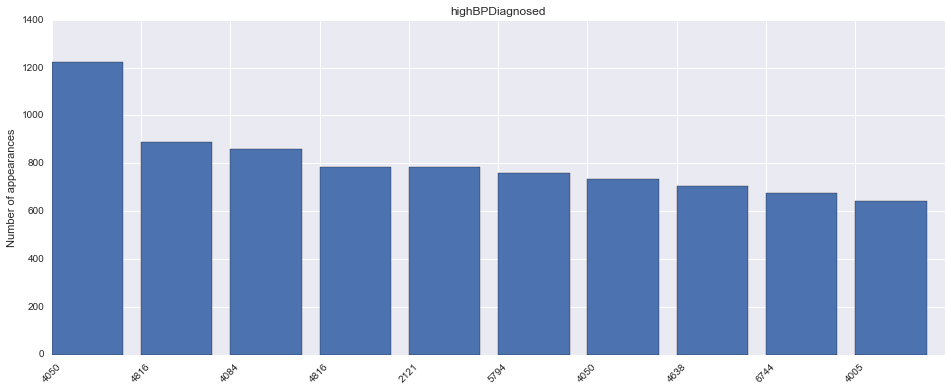

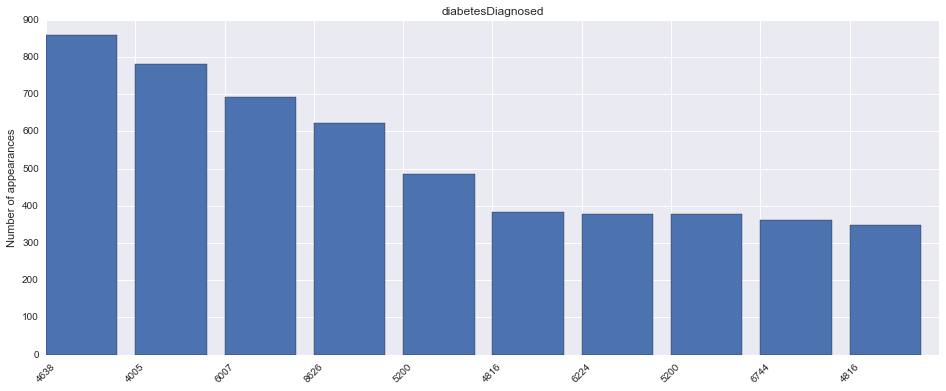

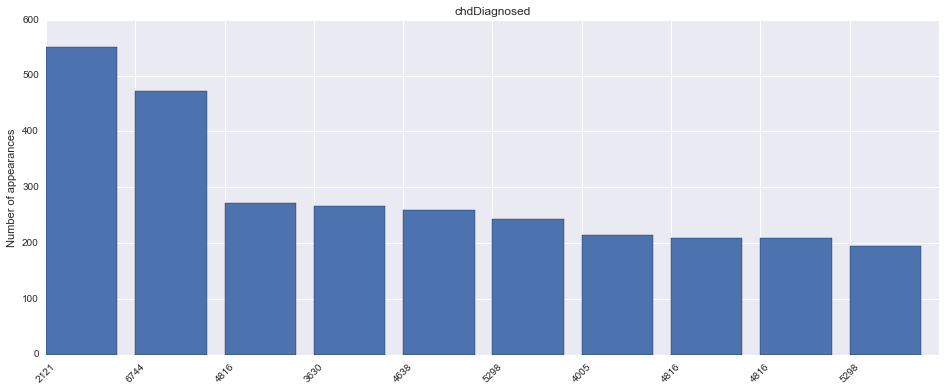

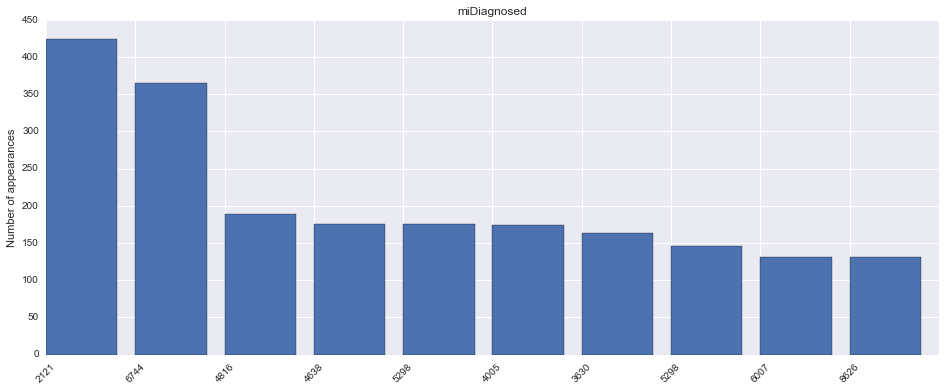

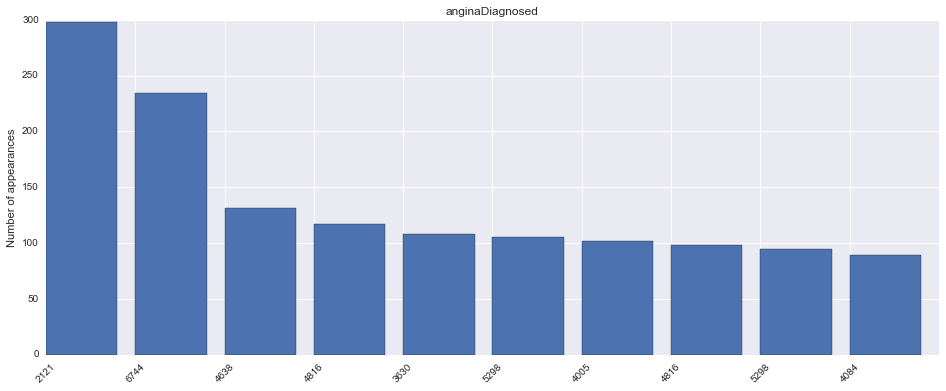

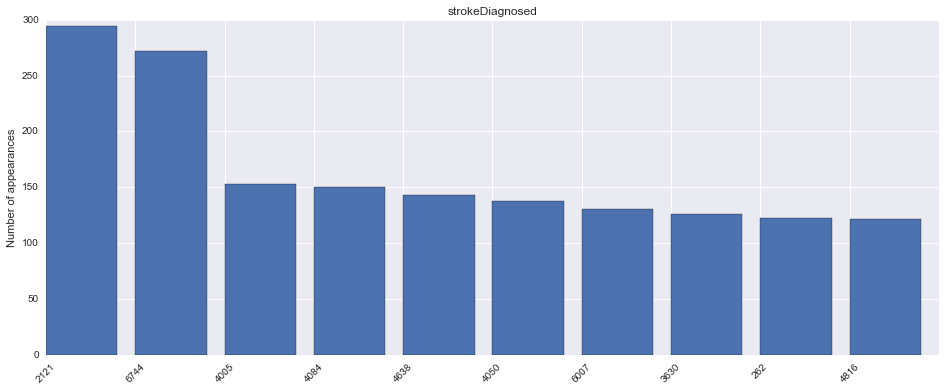

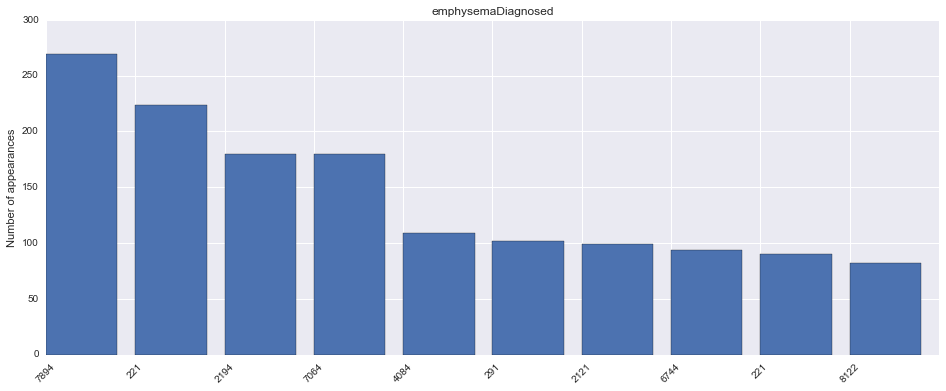

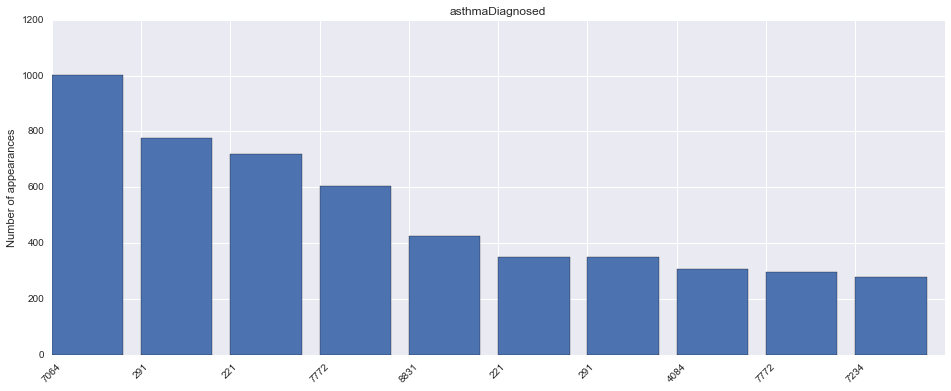

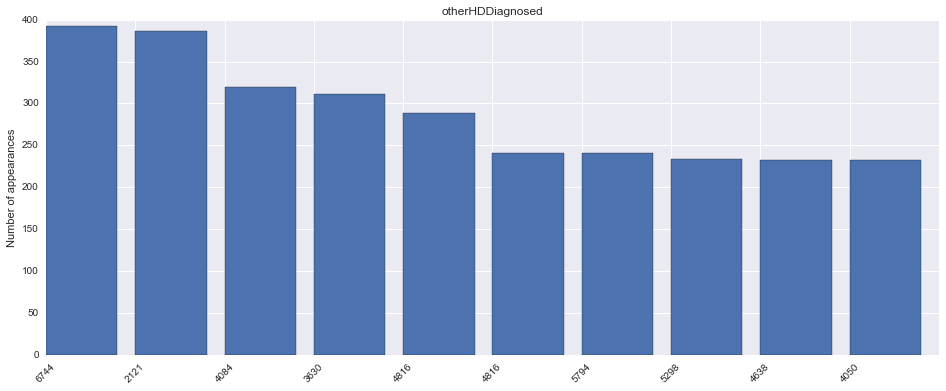

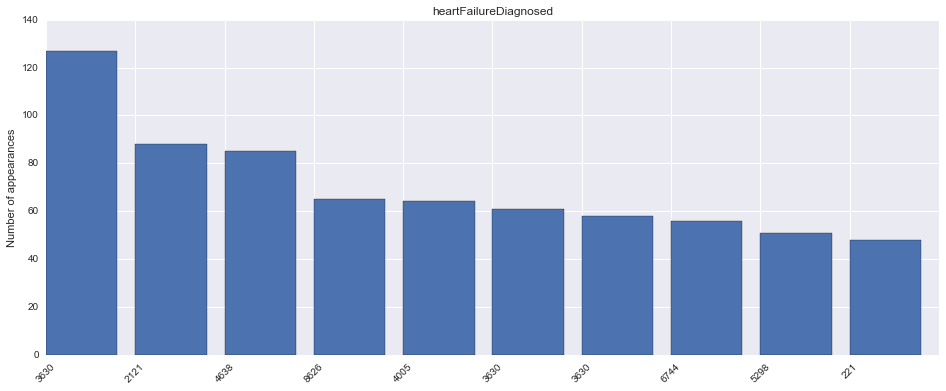

In [21]:
list_of_freq_meds = {}
for condition in conditions:
    freq = most_common_med(df, condition)
    # Percentage of patients this was prescribed
    if not is_empty(freq):
        list_of_freq_meds[condition] = freq
        print(float(freq.most_common()[0][1]) / len(df[df[condition]==4]) * 100)

## Medications most indicative of each condition

A medication most indicative of a disease is a medication that appears more frequently on the list of medications of people with that disease but less frequently on the list of people without that disease.

There are a few approaches that we can take towards this problem:
- Find people with only one condition and nothing else and then look at their medication. This would be problematic since some of these diseases are related. For example a person with a heart condition might suffer from a number of heart diseases.
- Define a metric that would show the distance between how high a medication is ranked in one disease and how low it is ranked in the rest. This also poses a few challenges, namely, it has probably a high computational complexity.

However, this second approach might be worth considering with a few limitations that we set on it:

 1. Let's consider only the top 10 medications for each disease
 2. Let's define the distance metric as:
 
     $$d_{i} = \sum_{\substack{h \in D \\ h \neq disease}}{i_{disease}^2 - j_{h}^2}$$
     
     Alternatively, we can define a different distance metric and the lower the distance the better a medicine indicates a disease:
     
     $$d_{i} = \sum_{\substack{h \in D \\ h \neq disease}}{i_{disease}^2 - (n-j)_{h}^2}$$

     where $i$ is ranking of the medication in the list of most common medication for the considered disease, $j$ is the ranking of the same medication in the list of every other disease. $D$ is the list of all diseases, $h$ is each disease in that list, and $n$ is the number of medications appearing in the list of each disease.

In [22]:
def med_distance(medication, list_dis, list_non):
    pass

In [23]:
%%time
list_med_ranks = {}
for disease, freq_meds in list_of_freq_meds.items():
    list_med_ranks[disease] = [item[0] for item in freq_meds.most_common()[:10]]
    
rank_df = pd.DataFrame.from_dict(list_med_ranks)
dist_df = pd.DataFrame(index=rank_df.index, columns=rank_df.columns)
# print(dist_df)

for disease in rank_df.columns:
    for med in rank_df[disease].iteritems():
        distance = 0
        med_idx = med[0]
        med = med[1]
        for non_disease in rank_df.columns:
            if non_disease != disease:
                try:
                    non_idx = rank_df[rank_df[non_disease] == med].notnull().index[0]
                except IndexError:
#                     print("Not found for this disease")
                    non_idx = 10  # if a medicine doesn't exist in the top 10 of the disease, 
                                  # punish it by increasing the weight for not being significant enough!
                distance += med_idx - non_idx
        dist_df.ix[med_idx, disease] =  - distance  # add a negative sign to make the distance positive and the more the distance, 
                                                    # the better the medication indicative of that disease

dist_df.head()


CPU times: user 800 ms, sys: 17.1 ms, total: 817 ms
Wall time: 815 ms


In [24]:
# This list contains dataframes, where the patient only has one disease and not the other one. 
# This can be used to find correlations between different diseases
df_non_list = []
number_of_patients_in_each_disease = []
for condition in conditions:
    df_cond = df[df[condition]==4]
#     print(df_cond.shape[0])  # number of patients in each category of disease
    number_of_patients_in_each_disease.append(df_cond.shape[0])
    non_conds = [cond for cond in conditions if cond != condition]
    for non_cond in non_conds:
        df_non_list.append(df_cond[df_cond[non_cond]!=4])


In [25]:
# print(len(df_non_list))

In [31]:
for i, subdf in enumerate(df_non_list):
    if i%9 == 0:
        print('==========================================')
    print('% of people with one disease and not the other: ', np.round(float(subdf.shape[0])/number_of_patients_in_each_disease[i/9]*100), ', total number of patients like this: ', subdf.shape[0])
#     print(subdf.shape)


% of people with one disease and not the other:  76.0 , total number of patients like this:  10400
% of people with one disease and not the other:  86.0 , total number of patients like this:  11791
% of people with one disease and not the other:  91.0 , total number of patients like this:  12420
% of people with one disease and not the other:  93.0 , total number of patients like this:  12719
% of people with one disease and not the other:  91.0 , total number of patients like this:  12436
% of people with one disease and not the other:  96.0 , total number of patients like this:  13026
% of people with one disease and not the other:  88.0 , total number of patients like this:  12014
% of people with one disease and not the other:  82.0 , total number of patients like this:  11175
% of people with one disease and not the other:  97.0 , total number of patients like this:  13283
% of people with one disease and not the other:  25.0 , total number of patients like this:  1103
% of people

By examining the results, it can be seen that the most common disease is the **high blood pressure** and the least common is the **heart failure**. 

## Building a model - Future work
For a model to predict the diagnosis based on the medications, a naive approach would be to make a $M\times N$ sparce matrix, where $M$ is the number of patients, and $N$ is the number of medications, for each diagnosis. In this case, $N$ is either 9218 or 28736, depending on whether we want to take the name or NDC for identifying medications. This approach is of course not very practical because of the size of the matrix and computational complexity. 

A different approach would be to make a $M\times N$ matrix, $M$ beig the number of patients, and $N$ is the presence of the top 20 medications (this can later be optimized) present for each disease. So, for example, take the presence or absense of the over-all top 20 medications and build the feature set based on those for each disease, or take the entire set of 10 diseases in this dataset as the label and train for it. As extra features, include age, sex, and weight. 

To extend this model, we can use the `raw_cond` dataframe that's loaded from `meps_conditions.csv`, to add more diagnosis data to our label and while doing that, we also need to consider more medications to increase the accuracy of the results.

For the choice of classifier, at first a decision tree for finding the best features, and later train a random forest would be one option.

These are some of the ideas worth exploring.

In [27]:
df.head()

,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed,rxNDC,rxName
1,10007101,15,3603.881236,28,Male,White,MARRIED,4,2,2,2,2,2,2,2,2,2,"[68382002210, 59762314001, 51079068463]","[919, 1041, 919]"
2,10007102,15,2544.550424,25,Female,White,MARRIED,2,2,2,2,2,2,2,4,2,2,"[173075000, 406036005, 603258228]","[8474, 4084, 1668]"
3,10007103,15,4050.397468,4,Male,White,UNDER 16 - INAPPLICABLE,1,1,1,1,1,1,1,2,1,2,[65401303],[8892]
4,10007104,15,3064.059720,3,Female,White,UNDER 16 - INAPPLICABLE,1,1,1,1,1,1,1,2,1,2,"[143988775, 68032032814]","[614, 6329]"
5,10008101,15,3635.552466,51,Male,Multiple,MARRIED,2,2,2,2,2,2,2,2,2,2,NaN,NaN


### Average number of medications for each disease

In [28]:
df_hbp = df[df['highBPDiagnosed']==4]
df_hbp.head()
df['rxNDC'].fillna(value=0, inplace=True)
df['rxName'].fillna(value=0, inplace=True)
df['numberMedication'] = [len(x)  if isinstance(x, list) else 0 for x in df['rxName'].tolist()]

In [29]:
df.describe()

,id,panel,pooledWeight,age,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed,numberMedication
count,6.148900e+04,61489.000000,61489.000000,61489.000000,61489.000000,61489.000000,61489.000000,61489.000000,61489.000000,61489.000000,61489.00000,61489.000000,61489.000000,61489.000000,61489.000000
mean,5.534638e+07,13.534453,5063.701982,33.578396,2.145180,1.843842,1.777830,1.752248,1.739124,1.753305,1.73231,2.177918,1.828473,2.014084,6.137455
std,2.759592e+07,1.061329,3815.885387,22.887576,1.080327,0.746605,0.634544,0.581053,0.553745,0.583137,0.53531,0.614064,0.722464,0.167242,9.932157
min,1.000710e+07,12.000000,127.710358,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000
25%,4.045510e+07,13.000000,2217.419038,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2.000000,1.000000,2.000000,0.000000
50%,4.965010e+07,14.000000,3989.180418,32.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000
75%,8.161711e+07,14.000000,6905.677619,51.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,8.000000
max,8.968810e+07,15.000000,38828.153564,85.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,4.000000,136.000000


So on average, patients take 6 different medications. The median is 2 medications per patient.

In [30]:
rank_df

,anginaDiagnosed,asthmaDiagnosed,chdDiagnosed,diabetesDiagnosed,emphysemaDiagnosed,heartFailureDiagnosed,highBPDiagnosed,miDiagnosed,otherHDDiagnosed,strokeDiagnosed
0,63653117101,59310057920,63653117101,88222033,597007541,378021610,172208380,63653117101,63653117106,63653117101
1,63653117106,17270072101,63653117106,2831501,173069600,63653117101,71015623,63653117106,63653117101,63653117106
2,88222033,173069600,71015623,169183411,597001314,88222033,406035705,71015623,406035705,2831501
3,71015623,6011731,378021610,56151088880,59310057920,56151088880,71015523,88222033,378021610,406035705
4,378021610,173068220,88222033,781505001,406035705,2831501,63653117101,378001801,71015623,88222033
5,378001801,173069500,378001801,71015623,17270072101,378020810,186504031,2831501,71015523,172208380
6,2831501,59930156001,2831501,53885044801,63653117101,781196610,603385632,378021610,186504031,169183411
7,71015523,406035705,71015523,781505201,63653117106,63653117106,88222033,378003210,378001801,378021610
8,378003210,6011754,71015723,63653117106,173069700,378001801,63653117106,169183411,88222033,597000160
9,406035705,85113201,378003210,71015523,186037020,173069600,2831501,56151088880,172208380,71015623
